In [13]:
%matplotlib inline
import pandas as pd
import pickle
from tqdm import tqdm
import numpy as np
# import os
# import scipy.stats as st

In [1]:
def input_paths(proj_path):

    input_paths_dict = {'QUIZC_cids_inchi_smiles_path': proj_path + 'QUIZC_drug_CIDs_inchi_smiles.csv',
                        'tool_path': proj_path + 'QUIZC_activityStats_nooutliers_df_besttool.csv',
                        'L1000_gene_info_path': proj_path + 'GSE92742_Broad_LINCS_gene_info.txt',
                        'L1000_cell_info_path': proj_path + 'GSE92742_Broad_LINCS_cell_info.txt',
                        'L1000_inst_info_path': proj_path + 'GSE92742_Broad_LINCS_inst_info.txt',
                        'L1000_pert_info_path': proj_path + 'GSE92742_Broad_LINCS_pert_info.txt',
                        'L1000_sig_info_path': proj_path + 'GSE92742_Broad_LINCS_sig_info.txt',

                        'pos_edges_dict_path': proj_path + 'cell_pos_edges_dict_75.pickle',
                        'neg_edges_dict_path': proj_path + 'cell_neg_edges_dict_75.pickle',
                        'drugs_dict_path': proj_path + 'cell_drugs_dict_75.pickle',

                        'cgp_dir': proj_path + 'c2.cgp.v7.1.symbols.gmt',

                        'Enrichr_GEO_up_path': proj_path + 'Disease_Perturbations_from_GEO_up.txt',
                        'Enrichr_GEO_dn_path': proj_path + 'Disease_Perturbations_from_GEO_down.txt',

                        'TTD_drugs_path': proj_path + 'P1-02-TTD_drug_download.txt',
                        'TTD_InChI2CID_path': proj_path + 'TTD_drugs_InChI2CID.txt',
                        'TTD_drug_target_path': proj_path + 'P1-07-Drug-TargetMapping.csv',
                        'TTD_target_path': proj_path + 'P1-01-TTD_target_download.txt',
                        'MODZ_networks_path': proj_path + 'MODZ_networks/',
                        'CD_networks_path': proj_path + 'CD_networks/'}
    
    return input_paths_dict

In [2]:
def import_L1000_metadata(L1000_gene_info_path, L1000_cell_info_path, L1000_inst_info_path, L1000_pert_info_path, L1000_sig_info_path):

    L1000_gene_info = pd.read_csv(L1000_gene_info_path, sep='\t', low_memory=False)
    L1000_cell_info = pd.read_csv(L1000_cell_info_path, sep='\t', low_memory=False)
    L1000_inst_info = pd.read_csv(L1000_inst_info_path, sep='\t', low_memory=False)
    L1000_pert_info = pd.read_csv(L1000_pert_info_path, sep='\t', low_memory=False)
    L1000_sig_info = pd.read_csv(L1000_sig_info_path, sep='\t', low_memory=False)
    
    return L1000_gene_info, L1000_cell_info, L1000_inst_info, L1000_pert_info, L1000_sig_info

In [3]:
def process_QUIZC_output(pos_edges_dict_path, neg_edges_dict_path, drugs_dict_path, L1000_gene_info):

    with open(pos_edges_dict_path, 'rb') as handle:
        cell_pos_edges_dict = pickle.load(handle)
    with open(neg_edges_dict_path, 'rb') as handle:
        cell_neg_edges_dict = pickle.load(handle)
    with open(drugs_dict_path, 'rb') as handle:
        cell_drugs_dict = pickle.load(handle)     
    
    edgelist_df_dict = {}
    nodelist_df_dict = {}
    for c in tqdm(cell_drugs_dict.keys(), position=0, leave=True):

        pos_edges_df = pd.DataFrame(np.array([(i, j) for i, j in zip(cell_drugs_dict[c], cell_pos_edges_dict[c])])).explode(1)
        neg_edges_df = pd.DataFrame(np.array([(i, j) for i, j in zip(cell_drugs_dict[c], cell_neg_edges_dict[c])])).explode(1)

        pos_edges_df = pos_edges_df[~pd.isnull(pos_edges_df[1])]
        neg_edges_df = neg_edges_df[~pd.isnull(neg_edges_df[1])]

        pos_edges_df = pos_edges_df.reset_index(drop=True).rename(columns={0: 'Drug', 1: 'Target'})
        neg_edges_df = neg_edges_df.reset_index(drop=True).rename(columns={0: 'Drug', 1: 'Target'})

        pos_edges_df['Target'] = pos_edges_df['Target'].astype(int)
        neg_edges_df['Target'] = neg_edges_df['Target'].astype(int)

        pos_edges_df['Direction'] = 'Up'
        neg_edges_df['Direction'] = 'Down'

        pos_edges_df = pd.merge(pos_edges_df, L1000_gene_info, left_on='Target', 
                                right_on='pr_gene_id', how='left')[['Drug', 'pr_gene_symbol', 'Direction']]
        neg_edges_df = pd.merge(neg_edges_df, L1000_gene_info, left_on='Target', 
                                right_on='pr_gene_id', how='left')[['Drug', 'pr_gene_symbol', 'Direction']]

        all_edges_df = pd.concat([pos_edges_df, neg_edges_df]).rename(columns={'pr_gene_symbol': 'Target'})

        if len(all_edges_df) > 0:
            edgelist_df_dict[c] = all_edges_df 

            nodelist_df_dict_drug = pd.DataFrame(columns=['Id', 'Label', 'Type'])
            nodelist_df_dict_drug['Id'] = edgelist_df_dict[c]['Drug'].unique()
            nodelist_df_dict_drug['Label'] = edgelist_df_dict[c]['Drug'].unique()
            nodelist_df_dict_drug['Type'] = 'Drug'
            nodelist_df_dict_target = pd.DataFrame(columns=['Id', 'Label', 'Type'])
            nodelist_df_dict_target['Id'] = edgelist_df_dict[c]['Target'].unique()
            nodelist_df_dict_target['Label'] = edgelist_df_dict[c]['Target'].unique()
            nodelist_df_dict_target['Type'] = 'Gene'

            nodelist_df_dict[c] = pd.concat([nodelist_df_dict_drug, nodelist_df_dict_target])


    allcells = pd.DataFrame(sorted(list(nodelist_df_dict.keys())), columns=['Cell_type'])
    allgenes = pd.DataFrame(sorted(list(set(pd.concat(nodelist_df_dict)[pd.concat(nodelist_df_dict)['Type']=='Gene']['Id']))), columns=['Gene_symbol'])
    alldrugs = pd.DataFrame(sorted(list(set(pd.concat(nodelist_df_dict)[pd.concat(nodelist_df_dict)['Type']=='Drug']['Id']))), columns=['Pert_iname'])

    allnodes = pd.DataFrame(columns=['Node_name'])
    allnodes['Node_name'] = np.concatenate([allgenes['Gene_symbol'].values, alldrugs['Pert_iname'].values])
    allnodes['Node_ID'] = allnodes.index.values
    
    return edgelist_df_dict, nodelist_df_dict, allcells, allgenes, alldrugs, allnodes

## Set file paths

In [4]:
proj_input_path = '/Users/ardahalu/Research/CICS/L1000_project/Pathopticon_all_analyses/'
proj_output_path = '/Users/ardahalu/Research/CICS/L1000_project/Pathopticon_all_analyses/Pathopticon_all_analyses_outputs/'
input_paths_dict = input_paths(proj_input_path)

## Import L1000 metadata

In [7]:
L1000_gene_info, L1000_cell_info, L1000_inst_info, L1000_pert_info, L1000_sig_info = import_L1000_metadata(input_paths_dict['L1000_gene_info_path'], 
                                                                                                           input_paths_dict['L1000_cell_info_path'],
                                                                                                           input_paths_dict['L1000_inst_info_path'], 
                                                                                                           input_paths_dict['L1000_pert_info_path'], 
                                                                                                           input_paths_dict['L1000_sig_info_path'])

## Import cell type-specific gene-perturbation networks (QUIZ-C, MODZ, CD)

In [14]:
QUIZC_edgelist_df_dict, QUIZC_nodelist_df_dict, QUIZC_allcells, \
QUIZC_allgenes, QUIZC_alldrugs, QUIZC_allnodes = process_QUIZC_output(input_paths_dict['pos_edges_dict_path'], 
                                                                     input_paths_dict['neg_edges_dict_path'],
                                                                     input_paths_dict['drugs_dict_path'],
                                                                     L1000_gene_info)

100%|██████████| 61/61 [00:03<00:00, 19.93it/s]


# Calculate Selectivity and Tool scores
**- Don't forget to make this specific to the drugs in the newest version of the QUIZC networks that we use, even if the drugs are not that different between versions. Currently the "QUIZC_cids_inchi_smiles_allcids.csv" file is for the old QUIZCs that Namitra generated.** <br>
**- Keep track of Pert_inames that have multiple CIDs mapped to them.** <br>

## Map QUIZC drugs to CIDs
**QUIZC-independent files used:** <br>
(1) "L1000_inchi_key2cid.txt" Contains all the drugs with InChI keys in the master L1000 perturbation file ("GSE92742_Broad_LINCS_pert_info.txt"). The InChI keys were uploaded to the PubChem Identifier Exchange and this is the file containing the InChI key to PubChem CID mapping. This file contains all the drugs in L1000 with InChIs, therefore it is not QUIZC network dependent but encompasses all drugs in QUIZC networks. <br>
(2) "L1000_SMILES2cid.txt" Same as above but for SMILES keys instead of InChI keys. <br>
**QUIZC-dependent files generated:** <br>
(1) "QUIZC_drug_CIDs_inchi_smiles.csv" This is the file that maps QUIZC drugs' pert_inames to PubChem CIDs through both InChI and SMILES keys. Since in the code below "allgenes" is used, this output file will be generated for whichever QUIZC network version is used as input. <br>
(2) "QUIZC_cids_inchi_smiles_allcids.csv" This is the file that contains all the QUIZC PubChem CIDs to be fed into ChemMineR to calculate Tanimoto Similarity scores. Since it uses "QUIZC_drug_CIDs_inchi_smiles.csv", it, too, is dependent on the specific set of QUIZC networks used as input. <br>

In [15]:
### conversion from pert_iname to CID through InChI and SMILES keys (we got those from the PubChem Identifier Exchange)
# InChI to CID
inchi_key2cid = pd.read_csv(proj_input_path + 'L1000_inchi_key2cid.txt', sep='\t')

QUIZC_inchi_keys = pd.merge(QUIZC_alldrugs, L1000_pert_info, how='left', left_on='Pert_iname', right_on='pert_iname')[['Pert_iname', 'inchi_key']]
QUIZC_inchi_keys = QUIZC_inchi_keys[QUIZC_inchi_keys['inchi_key'] != '-666']
QUIZC_inchi_keys = QUIZC_inchi_keys.drop_duplicates()

QUIZC_cids_inchi = pd.merge(QUIZC_inchi_keys, inchi_key2cid, how='left', left_on='inchi_key', right_on='inchi_key')[['Pert_iname', 'pubchem_cid']]
QUIZC_cids_inchi = QUIZC_cids_inchi[~pd.isnull(QUIZC_cids_inchi['pubchem_cid'])]

# SMILES to CID
smiles2cid = pd.read_csv(proj_input_path + 'L1000_SMILES2cid.txt', sep='\t')

QUIZC_smiles = pd.merge(QUIZC_alldrugs, L1000_pert_info, how='left', left_on='Pert_iname', right_on='pert_iname')[['Pert_iname', 'canonical_smiles']]
QUIZC_smiles = QUIZC_smiles[QUIZC_smiles['canonical_smiles'] != '-666']
QUIZC_smiles = QUIZC_smiles.drop_duplicates()

QUIZC_cids_smiles = pd.merge(QUIZC_smiles, smiles2cid, how='left', left_on='canonical_smiles', right_on='SMILES')[['Pert_iname', 'pubchem_cid']]
QUIZC_cids_smiles = QUIZC_cids_smiles[~pd.isnull(QUIZC_cids_smiles['pubchem_cid'])]

QUIZC_cids_inchi_smiles = pd.merge(QUIZC_cids_smiles, QUIZC_cids_inchi, how='outer', left_on='Pert_iname', right_on='Pert_iname')

# finally, complete the missing values by copying the corresponding values from the one of "pubchem_cid_x" or "pubchem_cid_y" 
for ix in QUIZC_cids_inchi_smiles.index[pd.isnull(QUIZC_cids_inchi_smiles['pubchem_cid_x'])]:
    QUIZC_cids_inchi_smiles.at[ix, 'pubchem_cid_x'] = QUIZC_cids_inchi_smiles.loc[ix]['pubchem_cid_y']
    
for ix in QUIZC_cids_inchi_smiles.index[pd.isnull(QUIZC_cids_inchi_smiles['pubchem_cid_y'])]:
    QUIZC_cids_inchi_smiles.at[ix, 'pubchem_cid_y'] = QUIZC_cids_inchi_smiles.loc[ix]['pubchem_cid_x']

QUIZC_cids_inchi_smiles.to_csv(proj_output_path + 'QUIZC_drug_CIDs_inchi_smiles.csv', index=False)

# write the new (expanded) set of CIDs to be input into ChemmineR for fingerprint retrieval
f = open(proj_output_path + 'QUIZC_cids_inchi_smiles_allcids.csv', 'w')
f.write('pubchem_cid\n')
for cid in sorted(list(set(QUIZC_cids_inchi_smiles[~pd.isnull(QUIZC_cids_inchi_smiles['pubchem_cid_x'])]['pubchem_cid_x'].astype(int)) | \
    set(QUIZC_cids_inchi_smiles[~pd.isnull(QUIZC_cids_inchi_smiles['pubchem_cid_y'])]['pubchem_cid_y'].astype(int)))):
    f.write('%s\n' % cid)
f.close()

## Import ChEMBL data and match with QUIZC drugs and targets
**Has to be done only once for a set of input QUIZC networks. Once we finalize which QUIZC version to use, this section can be commented out.** <br>
**QUIZC-independent input files used:** <br>
(1) "CHEMBL27_human_singleprotein.csv" The master ChEMBLv27 file that includes all the drug activity information for Single Protein targetds in H.Sapiens <br>
(2) "chembl_uniprot_mapping.txt" The ChEMBL to UniProt mapping for the target genes in ChEMBL v27, downloaded from ChEMBL website (ftp://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/latest/). <br>
(3) "HugoGene_20200528.txt" The UniProt to Gene Symbol and Entrez ID mapping from HUGO Gene Nomenclature Committee website (https://www.genenames.org/), used to map ChEMBL IDs of the targets to Gene Symbols and Entrez IDs. Retrieved on the date as in the filename. <br>
(4) "ChEMBL27_human_singleprotein_ChEMBL2PubChem.txt" The ChEMBL ID to CID mapping of all the drugs in "CHEMBL27_human_singleprotein.csv". <br>
**QUIZC-dependent input files used:** <br>
(1) "QUIZC_cids_inchi_smiles_allcids.csv"  The file that contains all the QUIZC PubChem CIDs. <br>

**QUIZC-independent outputs:** <br>
(1) "ChEMBL27_human_singleprotein_ChEMBL_IDs.csv" File containing all unique ChEMBL IDs in ""CHEMBL27_human_singleprotein.csv", to be input into PubChem IDEX for conversion into CIDs. This file was split into 3 files of <=400,000 lines since there were a little over 1M IDs and queries were capped at 500K. The results of the three ChEMBL_ID-to-CID mapping files from IDEX were concatenated to form "ChEMBL27_human_singleprotein_ChEMBL2PubChem.txt" <br>
**QUIZC-dependent outputs:** <br>
(1) "ChEMBL27_human_singleprotein_QUIZC.txt" This is the subset of ChEMBLv27 activity data with compounds and targets in QUIZC networks, in CID and Gene Symbol/Entrez ID format. <br>
(2) "ChEMBL27_human_singleprotein_QUIZC_CIDs.txt" All acitivity information for the compounds QUIZC networks. The difference of this from the above is the this file contains activities of all targets of the QUIZC drugs, whereas the above contains only the activities between the drugs and targets in QUIZC. **This is the main file that is used in the Selectivity and Tool Score calculation below.**<br>

In [709]:
chembl27_data = pd.read_csv(proj_input_path + 'external_data/' + 'CHEMBL27_human_singleprotein.csv', sep=';')

# 9 lines are missing the Compound Key entry, excluding those
chembl27_data = chembl27_data[~pd.isnull(chembl27_data['Compound Key'])]

In [1226]:
# Write all unique ChEMBL IDs to file for conversion to CIDs in PubChem Identifier Exchange
# Note: I had to (manually) break the below file into 3 files of <=400,000 lines since there are a little over 1M IDs 
# and queries are capped at 500K.
f = open('/Users/ardahalu/Desktop/QUIZC_final_figures/ChEMBL27_human_singleprotein_ChEMBL_IDs.csv', 'w')
for i in set(chembl27_data['Molecule ChEMBL ID']):
    f.write('%s\n' % i)
f.close()

In [710]:
# Import the ChEMBL ID to PubChem CID mappings downloaded from PubChem Identifier Exchange (manually merged from the three files above)
ChEMBL2PubChem = pd.read_csv(proj_input_path + 'ChEMBL27_human_singleprotein_ChEMBL2PubChem.txt', 
                             sep='\t', header=None)
print(len(ChEMBL2PubChem))
ChEMBL2PubChem = ChEMBL2PubChem[~pd.isnull(ChEMBL2PubChem[1])]
print(len(ChEMBL2PubChem))
ChEMBL2PubChem[1] = ChEMBL2PubChem[1].astype(int)

# Map the compound ChEMBL IDs in the activity data to CIDs
chembl27_data_CID = pd.merge(chembl27_data, ChEMBL2PubChem, left_on='Molecule ChEMBL ID', right_on=0)

# UniProt ID mappings of all ChEMBL targets (downloaded from ftp://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/latest/)
chembl27_uniprot = pd.read_csv(proj_input_path + 'chembl_uniprot_mapping.txt', sep='\t', 
                               skiprows=1, header=None)
chembl27_uniprot = chembl27_uniprot.rename(columns={0: 'UniProt ID', 1: 'ChEMBL ID', 2: 'Protein name', 3: 'ChEMBL target type'})

# HUGO Gene name mappings (as of 28/05/2020)
HUGO_map = pd.read_csv(proj_input_path + 'HugoGene_20200528.txt', sep='\t')

# Convert ChEMBL targets to gene symbols and Entrez IDs using the HUGO Gene Names
chembl27_uniprot_entrez = pd.merge(chembl27_uniprot, HUGO_map, left_on='UniProt ID', right_on='UniProt ID(supplied by UniProt)')

# Map the target ChEMBL IDs in the activity data to Gene Symbols and Entrez IDs
chembl27_data_CID_entrez = pd.merge(chembl27_data_CID, chembl27_uniprot_entrez, left_on='Target ChEMBL ID', right_on='ChEMBL ID')
chembl27_data_CID_entrez = chembl27_data_CID_entrez.rename(columns={1: 'PubChem CID'})

1043625
1042400


In [711]:
# 2,148 of the 4,303 QUIZC CIDs have activity data in ChEMBL
# these 2,148 compounds have overall 235,159 activity records with 1,673 targets in ChEMBL, 
# of which 2,139 and 1,504 are in the QUIZC networks, respecitvely.
# so overall, for the QUIZC networks we have information on 221,987 activities between 2,139 compounds and 1,504 targets.
QUIZC_CIDs = pd.read_csv(proj_output_path + 'QUIZC_cids_inchi_smiles_allcids.csv')

print(len(set(chembl27_data_CID_entrez[chembl27_data_CID_entrez['PubChem CID']
                                       .isin(QUIZC_CIDs['pubchem_cid'])]['PubChem CID'])))
print(len(chembl27_data_CID_entrez[chembl27_data_CID_entrez['PubChem CID']
                                   .isin(QUIZC_CIDs['pubchem_cid'])]))
print(len(set(chembl27_data_CID_entrez[chembl27_data_CID_entrez['PubChem CID']
                                       .isin(QUIZC_CIDs['pubchem_cid'])]['NCBI Gene ID(supplied by NCBI)'])))
print(len(set(chembl27_data_CID_entrez[chembl27_data_CID_entrez['PubChem CID']
                                       .isin(QUIZC_CIDs['pubchem_cid'])]['Approved symbol'])))
print(len(set(chembl27_data_CID_entrez[(chembl27_data_CID_entrez['NCBI Gene ID(supplied by NCBI)']
                                       .isin(L1000_gene_info['pr_gene_id'].astype(float))) & 
                                      (chembl27_data_CID_entrez['PubChem CID']
                                       .isin(QUIZC_CIDs['pubchem_cid']))]['NCBI Gene ID(supplied by NCBI)'])))
print(len(set(chembl27_data_CID_entrez[(chembl27_data_CID_entrez['NCBI Gene ID(supplied by NCBI)']
                                       .isin(L1000_gene_info['pr_gene_id'].astype(float))) & 
                                      (chembl27_data_CID_entrez['PubChem CID']
                                       .isin(QUIZC_CIDs['pubchem_cid']))]['PubChem CID'])))
print(len(chembl27_data_CID_entrez[(chembl27_data_CID_entrez['NCBI Gene ID(supplied by NCBI)']
                                       .isin(L1000_gene_info['pr_gene_id'].astype(float))) & 
                                      (chembl27_data_CID_entrez['PubChem CID']
                                       .isin(QUIZC_CIDs['pubchem_cid']))]))

# overall number of compounds and targets with activity data (H. Sapiens + single protein target) in ChEMBL
print(len(set(chembl27_data_CID_entrez['Molecule ChEMBL ID'])), len(set(chembl27_data_CID_entrez['NCBI Gene ID(supplied by NCBI)'])))

2148
235159
1673
1673
1504
2139
221987
1037122 3448


In [712]:
# subset of ChEMBL activity data with compounds and targets in QUIZC networks
chembl27_QUIZC = chembl27_data_CID_entrez[(chembl27_data_CID_entrez['NCBI Gene ID(supplied by NCBI)']
                                          .isin(L1000_gene_info['pr_gene_id'].astype(float))) & 
                                         (chembl27_data_CID_entrez['PubChem CID'].isin(QUIZC_CIDs['pubchem_cid']))]
chembl27_QUIZC.to_csv(proj_output_path + 'ChEMBL27_human_singleprotein_QUIZC.txt', sep='\t', index=False)

# subset of ChEMBL activity data with compounds in QUIZC networks (note the difference from the above  "ChEMBL27_human_singleprotein_QUIZC.txt", 
# which is the ChEMBL binding information between QUIZC drugs AND QUIZC targets)
chembl27_QUIZC_CIDs = chembl27_data_CID_entrez[chembl27_data_CID_entrez['PubChem CID'].isin(QUIZC_CIDs['pubchem_cid'])]
chembl27_QUIZC_CIDs.to_csv(proj_output_path + 'ChEMBL27_human_singleprotein_QUIZC_CIDs.txt', sep='\t', index=False)

## Calculate Selectivity and Tool scores
-We use nM activity data from ChEMBL to quantify selectivity and tool scores. <br>
-For each drug (CID), all its targets with nM activity information in ChEMBLv27 are collected. <br>
-Within the set of targets, eact target is sequentially taken as the "on-target", and the remaining targets are labeled as the "off-targets." <br>
-ChEMBL data is cleaned to remove negative nM values. <br>
-If both on- and off-targets exist, we assign strength values 1, 4 and 7 if x<=100nM, 100<x<=1000nM and x>1000nM, respectively (as per [Nienke Moret et al. Cell Chem Biol 2019](https://www.cell.com/cell-chemical-biology/fulltext/S2451-9456(19)30073-X?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS245194561930073X%3Fshowall%3Dtrue#secsectitle0080)) <br>
-We calculate data bias as per the paper above. <br>
-We calculate the difference between the upper (3rd) and lower (1st) quartiles of the nM activity distributions, as per [Yuan Wang et al. Cell Chem Biol 2016](https://www.cell.com/cell-chemical-biology/fulltext/S2451-9456(16)30196-9?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS2451945616301969%3Fshowall%3Dtrue#supplementaryMaterial). <br>
-We calculate Selectivity and Tool score as defined in [Yuan Wang et al. Cell Chem Biol 2016](https://www.cell.com/cell-chemical-biology/fulltext/S2451-9456(16)30196-9?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS2451945616301969%3Fshowall%3Dtrue#supplementaryMaterial) and [Nienke Moret et al. Cell Chem Biol 2019](https://www.cell.com/cell-chemical-biology/fulltext/S2451-9456(19)30073-X?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS245194561930073X%3Fshowall%3Dtrue#secsectitle0080), using Q1 difference and capping K-S p-value at 1e-16. <br>
-We then remove outliers from Selectivity by removing points outside of [Q1-4\*IQR, Q3+4\*IQR]. Since Tool Scores are skewed my the assigned Strength values, ee remove the outliers in Tool Scores manually by excluding Tool Scores above 7.5. <br>
-We finally scale the Selectivity and Tool scores. <br>
**NOTES:** <br>
-Data bias is the ratio of the on-target measurements to all measurements for a given drug-target pair. If there are no off-target measurements, the measurement is severely biased, therefore the data bias is 100%. The higher the number of off-target measurements, the less biased the measurement becomes (Data bias tends to zero). In the Selectivity and Tool Score calculations, we use (1-Data bias) to favor drugs with low bias. <br>
-The selectivity and Tool scores are calculated for each drug-target pair. When prioritizing drugs, we collapse all the drug-target pairs for a given drug to a single value by selecting the highest selectivity/tool score for that drug. __To be fixed__: .max() yields the max of each column whereas we want the values corresponding only to the max selectivity or tool score **[FIXED]**<br>
-


In [16]:
def calculate_selectivity_tool(proj_input_path, proj_output_path):
    
    QUIZC_CIDs = pd.read_csv(proj_output_path + 'QUIZC_cids_inchi_smiles_allcids.csv')
    chembl27_QUIZC_CIDs = pd.read_csv(proj_output_path + 'ChEMBL27_human_singleprotein_QUIZC_CIDs.txt', sep='\t', low_memory=False )
    
    
    activityStats_df = pd.DataFrame()
    for cid in tqdm(chembl27_QUIZC_CIDs['PubChem CID'].sort_values().drop_duplicates(), position=0, leave=True):

        temp_cid_df = chembl27_QUIZC_CIDs[(chembl27_QUIZC_CIDs['Standard Units'] == 'nM') &
                                         (chembl27_QUIZC_CIDs['Standard Relation'] == "'='") &
                                         (chembl27_QUIZC_CIDs['PubChem CID']==cid)]
        cid_targets = set(temp_cid_df['NCBI Gene ID(supplied by NCBI)'])
        temp_on_nM = {}
        temp_off_nM = {}
        for on_t in cid_targets:
            off_t = cid_targets - set([on_t])
            temp_on_nM[on_t] = temp_cid_df[temp_cid_df['NCBI Gene ID(supplied by NCBI)']==on_t]['Standard Value'].values
            temp_off_nM[on_t] = temp_cid_df[temp_cid_df['NCBI Gene ID(supplied by NCBI)'].isin(off_t)]['Standard Value'].values

            # remove measurements with negative nM values, if any   
            temp_on_nM[on_t] = temp_on_nM[on_t][temp_on_nM[on_t] > 0]
            temp_off_nM[on_t] = temp_off_nM[on_t][temp_off_nM[on_t] > 0]

            if (len(temp_on_nM[on_t]) > 0) & (len(temp_off_nM[on_t]) > 0):

                if (len(temp_on_nM[on_t][temp_on_nM[on_t] <= 100.0]) > 1):
                    strength = 7
                elif (len(temp_on_nM[on_t][temp_on_nM[on_t] <= 1000.0]) > 4):
                    strength = 4
                else:
                    strength = 1

                data_bias = len(temp_on_nM[on_t]) / (len(temp_on_nM[on_t]) + len(temp_off_nM[on_t]))
                Q1_diff = np.quantile(np.log10(temp_off_nM[on_t]), 0.25) - np.quantile(np.log10(temp_on_nM[on_t]), 0.25)
                Q3_diff = np.quantile(np.log10(temp_off_nM[on_t]), 0.75) - np.quantile(np.log10(temp_on_nM[on_t]), 0.75)

                KS_pval = st.ks_2samp(temp_on_nM[on_t], temp_off_nM[on_t])[1]
                if (KS_pval<1e-16): KS_pval = 1e-16

                selectivity = ((Q1_diff/3) + (-np.log10(KS_pval)/16.0) + (1 - data_bias)) / 3
                tool_score = selectivity * strength

                activityStats_df = activityStats_df.append(pd.DataFrame([cid, on_t, KS_pval, Q1_diff, Q3_diff, data_bias, 
                                                                         selectivity, strength, tool_score]).T)

    activityStats_df = activityStats_df.reset_index(drop=True).rename(columns={0: 'cid', 1: 'Target Entrez ID', 2: 'K-S p-value', 
                                                                               3: 'Q1_diff', 4: 'Q3_diff',  5: 'data_bias', 
                                                                               6: 'selectivity score', 7: 'strength', 8: 'tool score'})
    
    
    # Based on the distributions, remove the outliers.
    selectivity_Q1 =  activityStats_df['selectivity score'].quantile(0.25)
    selectivity_Q3 =  activityStats_df['selectivity score'].quantile(0.75)
    selectivity_IQR = selectivity_Q3 - selectivity_Q1
    selectivity_outliers_ix = activityStats_df[((activityStats_df['selectivity score'] < (selectivity_Q1 - (selectivity_IQR  * 4.0))) | 
                                   (activityStats_df['selectivity score'] > (selectivity_Q3 + (selectivity_IQR  * 4.0))))].index

    tool_outliers_ix = activityStats_df[activityStats_df['tool score'] >= 7.5].index

    nooutliers_ix = set(activityStats_df.index) - (set(selectivity_outliers_ix) | set(tool_outliers_ix))

    activityStats_df_nooutliers = activityStats_df.loc[nooutliers_ix]
    
    
    # Scale selectivity and tool scores
    sel_scale_len = (activityStats_df_nooutliers['selectivity score'].max() - activityStats_df_nooutliers['selectivity score'].min()) / 2
    sel_scale_diff = activityStats_df_nooutliers['selectivity score'].max() - sel_scale_len
    activityStats_df_nooutliers['selectivity score scaled'] = (activityStats_df_nooutliers['selectivity score'] - sel_scale_diff) / sel_scale_len

    tool_scale_len = (activityStats_df_nooutliers['tool score'].max() - activityStats_df_nooutliers['tool score'].min()) / 2
    tool_scale_diff = activityStats_df_nooutliers['tool score'].max() - tool_scale_len
    activityStats_df_nooutliers['tool score scaled'] = (activityStats_df_nooutliers['tool score'] - tool_scale_diff) / tool_scale_len
    
    
    # Merge with QUIZC_cids_inchi_smiles to get the pert_iname. Note that when we are writing to file we are collapsing drug-target pairs onto
    # the drug space. When we do so, we take the drug-target pairs with either the highest tool scores (first one below) or selectivity scores
    # (second one below). The resulting file name clarifies this choice.
    QUIZC_activityStats_nooutliers_df_besttool = pd.merge(activityStats_df_nooutliers.sort_values(['cid', 'tool score scaled'], ascending=[True, False])
                                                              .drop_duplicates('cid'), 
                                                              QUIZC_cids_inchi_smiles[['Pert_iname', 'pubchem_cid_x']], 
                                                              left_on='cid', right_on='pubchem_cid_x', how='inner').drop_duplicates()

    QUIZC_activityStats_nooutliers_df_besttool.to_csv(proj_output_path + 'QUIZC_activityStats_nooutliers_df_besttool.csv', 
                                                     index=False)

    QUIZC_activityStats_nooutliers_df_bestselectivity = pd.merge(activityStats_df_nooutliers.sort_values(['cid', 'selectivity score scaled'], 
                                                                                                        ascending=[True, False])
                                                                .drop_duplicates('cid'), 
                                                                QUIZC_cids_inchi_smiles[['Pert_iname', 'pubchem_cid_x']], 
                                                                left_on='cid', right_on='pubchem_cid_x', how='inner').drop_duplicates()

    QUIZC_activityStats_nooutliers_df_bestselectivity.to_csv(proj_output_path + 'QUIZC_activityStats_nooutliers_df_bestselectivity.csv', index=False)
    
    return QUIZC_activityStats_nooutliers_df_besttool, QUIZC_activityStats_nooutliers_df_bestselectivity

In [713]:
# import the CIDs of QUIZC drugs and the ChEMBL binding information on the QUIZC drugs
QUIZC_CIDs = pd.read_csv(proj_output_path + 'QUIZC_cids_inchi_smiles_allcids.csv')
chembl27_QUIZC_CIDs = pd.read_csv(proj_output_path + 'ChEMBL27_human_singleprotein_QUIZC_CIDs.txt', sep='\t', low_memory=False )

In [715]:
activityStats_df = pd.DataFrame()
for cid in tqdm(chembl27_QUIZC_CIDs['PubChem CID'].sort_values().drop_duplicates(), position=0, leave=True):
    
    temp_cid_df = chembl27_QUIZC_CIDs[(chembl27_QUIZC_CIDs['Standard Units'] == 'nM') &
                                     (chembl27_QUIZC_CIDs['Standard Relation'] == "'='") &
                                     (chembl27_QUIZC_CIDs['PubChem CID']==cid)]
    cid_targets = set(temp_cid_df['NCBI Gene ID(supplied by NCBI)'])
    temp_on_nM = {}
    temp_off_nM = {}
    for on_t in cid_targets:
        off_t = cid_targets - set([on_t])
        temp_on_nM[on_t] = temp_cid_df[temp_cid_df['NCBI Gene ID(supplied by NCBI)']==on_t]['Standard Value'].values
        temp_off_nM[on_t] = temp_cid_df[temp_cid_df['NCBI Gene ID(supplied by NCBI)'].isin(off_t)]['Standard Value'].values

        # remove measurements with negative nM values, if any   
        temp_on_nM[on_t] = temp_on_nM[on_t][temp_on_nM[on_t] > 0]
        temp_off_nM[on_t] = temp_off_nM[on_t][temp_off_nM[on_t] > 0]
        
        if (len(temp_on_nM[on_t]) > 0) & (len(temp_off_nM[on_t]) > 0):
                                    
            if (len(temp_on_nM[on_t][temp_on_nM[on_t] <= 100.0]) > 1):
                strength = 7
            elif (len(temp_on_nM[on_t][temp_on_nM[on_t] <= 1000.0]) > 4):
                strength = 4
            else:
                strength = 1
                            
            data_bias = len(temp_on_nM[on_t]) / (len(temp_on_nM[on_t]) + len(temp_off_nM[on_t]))
            Q1_diff = np.quantile(np.log10(temp_off_nM[on_t]), 0.25) - np.quantile(np.log10(temp_on_nM[on_t]), 0.25)
            Q3_diff = np.quantile(np.log10(temp_off_nM[on_t]), 0.75) - np.quantile(np.log10(temp_on_nM[on_t]), 0.75)
            
            KS_pval = st.ks_2samp(temp_on_nM[on_t], temp_off_nM[on_t])[1]
            if (KS_pval<1e-16): KS_pval = 1e-16
            
            selectivity = ((Q1_diff/3) + (-np.log10(KS_pval)/16.0) + (1 - data_bias)) / 3
            tool_score = selectivity * strength
                      
            activityStats_df = activityStats_df.append(pd.DataFrame([cid, on_t, KS_pval, Q1_diff, Q3_diff, data_bias, 
                                                                     selectivity, strength, tool_score]).T)
            
activityStats_df = activityStats_df.reset_index(drop=True).rename(columns={0: 'cid', 1: 'Target Entrez ID', 2: 'K-S p-value', 
                                                                           3: 'Q1_diff', 4: 'Q3_diff',  5: 'data_bias', 
                                                                           6: 'selectivity score', 7: 'strength', 8: 'tool score'})

100%|██████████| 2148/2148 [02:05<00:00, 17.13it/s]


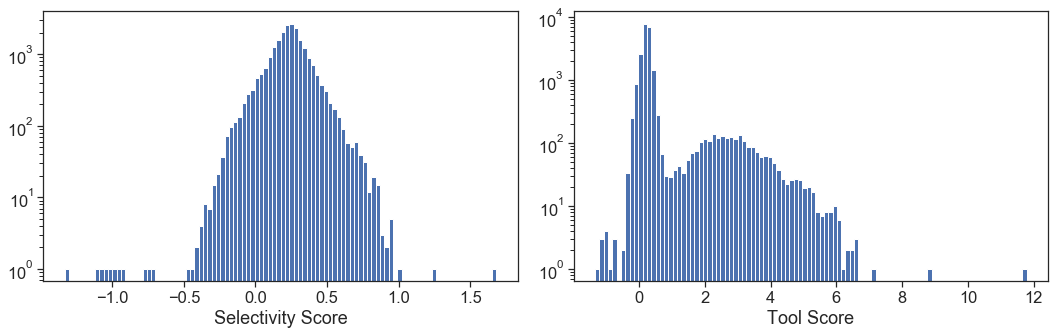

In [716]:
sns.set(font_scale=1.5)
with sns.axes_style('ticks'):
    fig = plt.figure()
    fig.set_size_inches(15, 5)  
    plt.subplot(1, 2, 1)
    plt.hist(activityStats_df['selectivity score'], bins=100)
    plt.yscale('log')
    plt.xlabel('Selectivity Score')
    plt.subplot(1, 2, 2)
    plt.hist(activityStats_df['tool score'], bins=100) 
    plt.yscale('log')
    plt.xlabel('Tool Score')
    plt.tight_layout()
    plt.show()

In [718]:
# Based on the above distributions, remove the outliers.
selectivity_Q1 =  activityStats_df['selectivity score'].quantile(0.25)
selectivity_Q3 =  activityStats_df['selectivity score'].quantile(0.75)
selectivity_IQR = selectivity_Q3 - selectivity_Q1
selectivity_outliers_ix = activityStats_df[((activityStats_df['selectivity score'] < (selectivity_Q1 - (selectivity_IQR  * 4.0))) | 
                               (activityStats_df['selectivity score'] > (selectivity_Q3 + (selectivity_IQR  * 4.0))))].index

tool_outliers_ix = activityStats_df[activityStats_df['tool score'] >= 7.5].index

nooutliers_ix = set(activityStats_df.index) - (set(selectivity_outliers_ix) | set(tool_outliers_ix))

activityStats_df_nooutliers = activityStats_df.loc[nooutliers_ix]

In [719]:
selectivity_Q1 - (selectivity_IQR  * 4.0), selectivity_Q3 + (selectivity_IQR  * 4.0)

(-0.4541947155608965, 0.9226960346462891)

In [720]:
# Scale selectivity and tool scores
sel_scale_len = (activityStats_df_nooutliers['selectivity score'].max() - activityStats_df_nooutliers['selectivity score'].min()) / 2
sel_scale_diff = activityStats_df_nooutliers['selectivity score'].max() - sel_scale_len
activityStats_df_nooutliers['selectivity score scaled'] = (activityStats_df_nooutliers['selectivity score'] - sel_scale_diff) / sel_scale_len

tool_scale_len = (activityStats_df_nooutliers['tool score'].max() - activityStats_df_nooutliers['tool score'].min()) / 2
tool_scale_diff = activityStats_df_nooutliers['tool score'].max() - tool_scale_len
activityStats_df_nooutliers['tool score scaled'] = (activityStats_df_nooutliers['tool score'] - tool_scale_diff) / tool_scale_len

In [721]:
# Merge with QUIZC_cids_inchi_smiles to get the pert_iname. Note that when we are writing to file we are collapsing drug-target pairs onto
# the drug space. When we do so, we take the drug-target pairs with either the highest tool scores (first one below) or selectivity scores
# (second one below). The resulting file name clarifies this choice.
QUIZC_activityStats_nooutliers_df_besttool = pd.merge(activityStats_df_nooutliers.sort_values(['cid', 'tool score scaled'], ascending=[True, False])
                                                          .drop_duplicates('cid'), 
                                                          QUIZC_cids_inchi_smiles[['Pert_iname', 'pubchem_cid_x']], 
                                                          left_on='cid', right_on='pubchem_cid_x', how='inner').drop_duplicates()

QUIZC_activityStats_nooutliers_df_besttool.to_csv(proj_output_path + 'QUIZC_activityStats_nooutliers_df_besttool.csv', 
                                                 index=False)

QUIZC_activityStats_nooutliers_df_bestselectivity = pd.merge(activityStats_df_nooutliers.sort_values(['cid', 'selectivity score scaled'], 
                                                                                                    ascending=[True, False])
                                                            .drop_duplicates('cid'), 
                                                            QUIZC_cids_inchi_smiles[['Pert_iname', 'pubchem_cid_x']], 
                                                            left_on='cid', right_on='pubchem_cid_x', how='inner').drop_duplicates()

QUIZC_activityStats_nooutliers_df_bestselectivity.to_csv(proj_output_path + 'QUIZC_activityStats_nooutliers_df_bestselectivity.csv', index=False)

# Tanimoto coefficient plots